<a href="https://colab.research.google.com/github/mykolesiko/egg_article/blob/main/MADE_RACNN_beta1_article2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.epochs = 2
    self.batch_size = 1000
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="/content/drive/MyDrive/MADE/Project/RACNN_models/"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

Сетка по статье https://drive.google.com/file/d/1ia3W9vgdZLurEx4R7ndVL05clQLEarKF/view?usp=sharing .

In [ ]:
def get_padding(in_size, kernel_size, stride):
    if (in_size % stride == 0):
        padding = max(kernel_size - stride, 0)
    else:
        padding = max(kernel_size - (in_size % stride), 0)
    return (padding)    

In [ ]:
def get_temporal_feature_extractor(input_size, batch_norm):
  pad = get_padding(input_size, 5,  2)
  conv1 = nn.Conv3d(1, 32, kernel_size = (1, 1, 5), stride=(1, 1, 2), padding=(0, 0, 2))
  bn1 = nn.BatchNorm3d(32)
  relu1 = nn.ReLU()
  pad = get_padding(input_size, 3,  2)
  conv2 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  bn2 = nn.BatchNorm3d(32)
  relu2 = nn.ReLU()
  conv3 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  bn3 = nn.BatchNorm3d(32)
  relu3 = nn.ReLU()
  conv4 = nn.Conv3d(32, 32, kernel_size = (1, 1, 16), stride=(1, 1, 16), padding=0)
  bn4 = nn.BatchNorm3d(32)
  relu4 = nn.ReLU()
  #print("11")
  if batch_norm == True:
      return (torch.nn.Sequential(conv1, bn1, relu1, conv2, bn2, relu2, conv3, bn3, relu3, conv4, bn4 ,relu4))
  else:
      return (torch.nn.Sequential(conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4))
  

In [ ]:
def get_regional_feature_extractor(batch_norm):
  conv1 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  bn1 =   nn.BatchNorm2d(32)
  relu1 = nn.ReLU()
  conv2 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  bn2 =   nn.BatchNorm2d(32)
  relu2 = nn.ReLU()
  if batch_norm == True:
      return(torch.nn.Sequential(conv1, bn1, relu1, conv2, bn2, relu2))
  else:    
      return(torch.nn.Sequential(conv1, relu1, conv2, relu2))

In [ ]:
class Asymmetric_feature_extractor(torch.nn.Module): 
   def __init__(self, batch_norm = True):
     super().__init__()
     self.conv = nn.Conv2d(32, 64, kernel_size = 1, stride=1 , padding='same')
     self.relu = nn.ReLU()
     self.bn =   nn.BatchNorm2d(64)
     self.batch_norm = batch_norm
   def forward(self, input):
     #input(bs, nf, h, w)
     #print(input.shape)
     half_mat = torch.split(input, (4, 1, 4), dim = 3)
     temp = half_mat[2][:, :, :, [3, 2, 1, 0]]
     input_new = half_mat[0] - temp
     #print(input_new)
     #print(half_mat[0].shape)
     #print(half_mat[2].shape)
     #input_new =  half_mat[0] -  half_mat[2]
     #print(input.shape)
     output = self.conv(input_new)
     if self.batch_norm:
          output = self.bn(output)
     output = self.relu(output)
     #print(output.shape)
     return output

def get_asymmetric_feature_extractor(batch_norm  = True):
    return (Asymmetric_feature_extractor())


In [ ]:
LEN_RECORD_IN_SECONDS = 60
NVIDEOS = 40
HCANALS = 9
WCANALS = 9
NTIMES_IN_SAMPLE = 128
NTIMES_IN_SEC = 128
NCANALS = 32
NFEATURES = 32
NSUBJECTS = 32
electrode_matrix = {}
electrode_matrix['FP1'] = [0, 3]
electrode_matrix['FP2'] = [0, 5]
electrode_matrix['AF3'] = [1, 3]
electrode_matrix['AF4'] = [1, 5]
electrode_matrix['F7']  = [2, 0]
electrode_matrix['F3']  = [2, 2]
electrode_matrix['FZ']  = [2, 4]
electrode_matrix['F4']  = [2, 6]
electrode_matrix['F8']  = [2, 8]
electrode_matrix['FC5']  = [3, 1]
electrode_matrix['FC1']  = [3, 3]
electrode_matrix['FC2']  = [3, 5]
electrode_matrix['FC6']  = [3, 7]
electrode_matrix['T7']  = [4, 0]
electrode_matrix['C3']  = [4, 2]
electrode_matrix['CZ']  = [4, 4]
electrode_matrix['C4']  = [4, 6]
electrode_matrix['T8']  = [4, 8]
electrode_matrix['CP5']  = [5, 1]
electrode_matrix['CP1']  = [5, 3]
electrode_matrix['CP2']  = [5, 5]
electrode_matrix['CP6']  = [5, 7]
electrode_matrix['P7']  = [6, 0]
electrode_matrix['P3']  = [6, 2]
electrode_matrix['PZ']  = [6, 4]
electrode_matrix['P4']  = [6, 6]
electrode_matrix['P8']  = [6, 8]
electrode_matrix['PO3'] = [7, 3]
electrode_matrix['PO4'] = [7, 5]
electrode_matrix['O1'] = [8, 3]
electrode_matrix['OZ'] = [8, 4]
electrode_matrix['O2'] = [8, 5]

list_electrodes = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'OZ',	'PZ',	'FP2',	'AF4', 'FZ', 'F4', 'F8', 'FC6',	'FC2',	'CZ', 'C4', 'T8', 'CP6',	'CP2',	'P4', 	'P8',	'PO4',	'O2']
data_dir = './data_preprocessed_python'
TRAIN_SIZE = 0.9
THRESHOLD = 4.5

In [ ]:
from collections import Counter
import scipy
from scipy.fft import fft, ifft


class RandomAugmentation(object):
    def __init__(self, augmenters, probability):
        self._augmenters = augmenters
        self.probability = probability

    def __call__(self, sample):
        augmenter = random.choice(self._augmenters)
        #print(augmenter)
        if (augmenter):
            if (np.random.random() < self.probability):
               return augmenter(sample)
        return(sample)  


class add_noise(object):
    def __init__(self, ):
        super(add_noise, self).__init__()

    def __call__(self, sample: dict):
        white_noise = np.random.normal(loc=0.0, scale=1.0, size=sample['data'].shape)
        sample['data'] = sample['data'] + white_noise
        return sample


class reset_part_in_time(object):
    def __init__(self, percentage):
        super(reset_part_in_time, self).__init__()
        self.percentage = percentage

    def __call__(self, sample: dict):
        len_data = len(sample['data'][0])
        interval_to_reset = int(len_data * self.percentage)
        for ncanal in range(NVIDEOS):
            begin = random.randint(0, len_data - interval_to_reset)
            sample['data'][ncanal, begin : begin + interval_to_reset] = 0

        return sample


class reset_part_in_freq(object):
    def __init__(self, percentage):
        super(reset_part_in_freq, self).__init__()
        self.percentage = percentage

    def __call__(self, sample: dict):
        len_data = len(sample['data'][0])
        interval_to_reset = int(len_data * self.percentage)
        power_freq_data = fft(sample['data'])
        for ncanal in range(NVIDEOS):
            begin = random.randint(0, len_data - interval_to_reset)
            power_freq_data[ncanal, begin : begin + interval_to_reset] = 0
        sample['data'] = ifft(power_freq_data)
        return sample

       

class to_head_matrix(object):
    def __init__(self):
        super(to_head_matrix, self).__init__()
        

    def __call__(self, sample: dict):
        input = sample['data'].copy()
        sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
        #sample_from_one_canals = []
        #for i_canal in range(NCANALS):
        #     sample_from_one_canal = input[i_canal]
        #     sample_from_one_canals.append(sample_from_one_canal)
        #print(sample_from_one_canal.shape)
        #sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      # здесь делаем нормализацию фактически по поверхности головы (по одному времени t для всех каналов)
        #sample_from_one_canals = scipy.stats.zscore(input, axis = 0)
        sample_from_one_canals = input
        for i_canal in range(NCANALS):
             sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
        return sample     

class ToTensor(object):

    def __init__(self, ):
        super(ToTensor, self).__init__()

    def __call__(self, sample: dict):
        return {"labels": torch.tensor(sample["labels"], dtype=torch.long),
                "data": torch.tensor(sample["data"], dtype=torch.float32),
                } 





class EmotionDataset(Dataset):
    def __init__ (self, data, labels_bin, transforms, indexes, interval = 1):  #indexes - индексы видео которые вошли в датасет, data - данные labels - метки бинарные
       self.data_samples = []
       self.labels = []
       self.transforms = transforms
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       for sub in range(len(data)): #sub   - человек
          for nvideo in range(NVIDEOS):
             
             for nsec in range(LEN_RECORD_IN_SECONDS):
                    self.data_samples.append(data[sub][nvideo, :,  (3 + nsec) * NTIMES_IN_SEC : (3 + nsec + interval) * NTIMES_IN_SEC])
                    self.labels.append(labels_bin[sub][nvideo, :])
                    

       self.data_samples = np.array(self.data_samples)[np.array(indexes)]
       self.labels = np.array(self.labels)[np.array(indexes)]
       for i in range(4):
          self.cnt[i].update(self.labels[:, i])
       

    def __len__(self):
       result =  len(self.data_samples)
       return result

    def __getitem__(self, item):
       sample = {}   
       sample = {"labels": self.labels[item],
                 "data": self.data_samples[item]
       }

       if self.transforms is not None:
           for t in self.transforms:
                sample = t(sample)
       #print(sample)         
       return sample
                 

In [ ]:
class EmotionNet(torch.nn.Module): 
   def __init__(self, hcanals, wcanals, nfeatures, ntimes_in_sample, batch_norm = True, reg_extractor = True, ass_extractor = True):
      super().__init__()
      #print("1")
      self.reg_extractor = reg_extractor
      self.ass_extractor = ass_extractor
      self.tfe = get_temporal_feature_extractor(ntimes_in_sample, batch_norm ) #(bs, 1, h = 9, w = 9, s = 128) -> (bs, h = 9, w = 9, s = 1)
      #print("2")
      if (reg_extractor):
          self.rfe = get_regional_feature_extractor(batch_norm) #(h = 9, w = 9, s = 32) -> (h = 9, w = 9, s = 32)
      #print("3")
      if ass_extractor:
          self.afe = get_asymmetric_feature_extractor(batch_norm)
      #print("4")
      self.flat1 = nn.Flatten(1, 3)
      self.flat2 = nn.Flatten(1, 3)
      self.input_linear_size = 0
      if (not reg_extractor and not ass_extractor) :
          self.input_linear_size =  hcanals * wcanals * nfeatures
      else:
          if (ass_extractor) :   
              self.input_linear_size += int(hcanals * (wcanals//2)* nfeatures * 2)
          if (reg_extractor) :   
              self.input_linear_size += hcanals * (wcanals)* nfeatures    
      #print(self.input_linear_size)
      #print("5")
      self.fc1 = nn.Linear(self.input_linear_size, 20)
      self.relu1 = nn.ReLU()
      self.drop = nn.Dropout(0.3)
      self.fc2 = nn.Linear(20, 2)
   def forward(self, input):
      input = input.unsqueeze(1)
      #print(f"input_shape = {input.shape}")
      
      #input (bs, in_canals = 1,  h=9, w=9, s=128)
      output_tfe = self.tfe(input)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      #output_tfe (bs, in_canals = 32,  h=9, w=9, s=1)
      output_tfe = output_tfe.squeeze(4)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      
      #output_rfe (bs, canals = 32,  h=9, w=9)

      if (self.reg_extractor) :   
            output_rfe = self.rfe(output_tfe)

      #print(f"output_rfe.shape = {output_rfe.shape}")
      if (self.ass_extractor) :   
            output_afe = self.afe(output_tfe)

      #output_rfe = output_rfe.permute(0, 2, 3, 1) 
      #output_rfe (bs, h=9, w=9, 32)
      #output_afe = output_afe.permute(0, 2, 3, 1) 
      #output_afe (bs, h=9, w=4, 64)
      #print(f"output_afe.shape = {output_afe.shape}")
      #output_rfe (bs, canals = 64,  h=4, w=9)
      if (self.reg_extractor) :   
          output_rfe_flatten = self.flat1(output_rfe)
      #print(f"output_rfe_flatten.shape = {output_rfe_flatten.shape}")
      if (self.ass_extractor) :   
          output_afe_flatten = self.flat2(output_afe)
      if (not self.reg_extractor and not self.ass_extractor) :          
          output_tfe_flatten = self.flat1(output_tfe)
          output1 = self.drop(self.fc1(output_tfe_flatten))
      if (self.reg_extractor) and (self.ass_extractor):   
          output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      else:    
          if (self.reg_extractor) :   
               output1 = self.drop(self.fc1(output_rfe_flatten))        
          if (self.ass_extractor) :   
               output1 = self.drop(self.fc1(output_afe_flatten))             

      #print(f"output_afe_flatten.shape = {output_afe_flatten.shape}")
      #output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      #print(f"output1.shape = {output1.shape}")
      output1_relu = self.relu1(output1)
      #print(f"output1_relu.shape = {output1_relu.shape}")
      output2 = self.fc2(output1_relu)
      #print(f"output2.shape = {output2.shape}")
      return output2


In [ ]:
def get_model(batch_norm = False, reg_extractor = True, ass_extractor = True):
  model = EmotionNet(HCANALS, WCANALS, NFEATURES, NTIMES_IN_SAMPLE, batch_norm, reg_extractor, ass_extractor).to(device)
  return model


Считываем данные

In [ ]:
import glob
import pickle
from sklearn.preprocessing import MinMaxScaler

data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))
data_raw = []
for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    labels.append(raw_data['labels'])
    #break

In [ ]:
len(files)


0

In [ ]:
# def remove_baseline():
#   for sub in range(NSUBJECTS):
#     for nvideo in range(NVIDEOS):
#         for ncanal in range(NCANALS):
#             baseline_mean = (data[sub][nvideo, ncanal, 0: 128] + data[sub][nvideo, ncanal, 128: 128  *2] + data[sub][nvideo, ncanal, 128 * 2: 128 * 3])/3
#             #print(baseline_mean.shape)
#             for nsec in range(60):
#                      data[sub][nvideo, ncanal, nsec * 128 : nsec * 128 + 128] = data[sub][nvideo, ncanal, nsec * 128 : nsec * 128 + 128] - baseline_mean

# remove_baseline()

In [ ]:
def normalize_data():
  for sub in range(NSUBJECTS):
    for nvideo in range(NVIDEOS):
        for ncanal in range(NCANALS):
             #std = np.std(data[sub][nvideo, ncanal, :])
             #data[sub][nvideo, ncanal, :] = np.clip(data[sub][nvideo, ncanal, :], -3 * std, 3 * std)
             scaler = MinMaxScaler(feature_range=(-1, 1))
             data[sub][nvideo, ncanal, :] = scaler.fit_transform(data[sub][nvideo, ncanal, :].reshape(-1, 1)).reshape(1, -1)
             #data[sub][nvideo, ncanal, :]  = data[sub][nvideo, ncanal, :]  - data[sub][nvideo, ncanal, :].mean()

normalize_data()

Бинаризуем метки и разбиваем видео для каждого человека в соответствии с метками этого человека - оно не всегда будет сбалансированным, как оказалось, но хотя бы метки буду представлены наиболее равномерно. Выведем количестов меток 1 для каждого человека в разбиении

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
k  = 5
labels_bin = []
for sub in range(32):
  temp = labels[sub] >= 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
  #print(sum(labels_bin[sub][:, type_emotion]), end=' ')




распределение положительных меток в датасете по каждой эмоции

In [ ]:
# print(train_dataset.cnt)
# print(val_dataset.cnt)


In [ ]:
def train(model, loader, criterion, optimizer, device, val_dataloader, val_f1_min,  description, type_emotion, batch = None, writer = None):
    model.train()
    train_loss = []
    inputs = []
    torch.autograd.set_detect_anomaly(True)
   
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for i , batch in enumerate(loader):#, total=len(loader), desc="training...", position=0 , leave = True)):
            model.train()
            optimizer.zero_grad()
            src  = batch['data'].to(device)
            trg = batch['labels'][:, type_emotion]
            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            if writer:
                writer.add_scalar(f'{description}/training loss per batch',
                                  loss.item(),
                                  i)

            # if (i % 100 == 0):
            #     acc, f1 = (calculate_predictions(model, val_dataloader))
            #     if (f1 > val_f1_min):
            #           val_f1_min      = f1
            #           torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join(args.output_dir, f"val.tgz"))
            #break
    return np.mean(train_loss), val_f1_min

def evaluate(model, loader, criterion, device, writer, description, type_emotion):
    
    model.eval()
    epoch_loss = 0
    history = []
  
    with torch.no_grad():
    
        for s, batch in enumerate(loader):#, total=len(loader), desc="validating...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]



            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 
            epoch_loss += loss.item() 


            if writer:
                writer.add_scalar(f'{description}/val loss per batch',
                                  loss.item(),
                                  s)
        
    return epoch_loss / s
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def calculate_predictions(model, loader, type_emotion, show):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    with torch.no_grad():

        for i, batch in enumerate(loader):#, total=len(loader), desc="predicting...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]
         

            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            #print(levels_pred.shape)
            trg_pred = levels_pred.argmax(1)
            
            real.extend(trg)
            pred.extend(trg_pred) 

        if show:    
            print(accuracy_score(real, pred)) 
            print(confusion_matrix(real, pred))  
            print(classification_report(real, pred))  
        f1 = ((f1_score(real, pred, average = 'binary', pos_label = 0))  + (f1_score(real, pred, average = 'binary', pos_label = 1)))/2
        return (accuracy_score(real, pred)) , f1
        #plt.hist(real)
def train_loop(description, type_emotion, n_epochs = 10):
    #args.epochs = 10
    #criterion =  fnn.mse_loss
    train_loss_min = 10000
    val_f1_min = -10000

    #batch = next(iter(train_dataloader))
    for epoch in range(n_epochs):
          #logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")
    
          train_loss, val_f1_min  = train(model, train_dataloader, criterion, optimizer ,device, val_dataloader, val_f1_min ,  description , type_emotion, None,  writer)
          #if epoch % 500 == 0:
          if writer:
                writer.add_scalar(f"{description}/training loss per epoch",
                                        train_loss,
                                        epoch)
          #print(train_loss)

          if (train_loss < train_loss_min):
                 train_loss_min      = train_loss
                 torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join(args.output_dir, "train.tgz")
            )  

          #val_loss = evaluate(model, val_dataloader, criterion, device,  writer, description )
          # #break
          #print(val_loss)
          #if writer:
          #      writer.add_scalar(f"{description}/val loss per epoch",
          #                        val_loss,
          #                        epoch)
          acc, f1 = (calculate_predictions(model, val_dataloader, type_emotion, False))
          #print(acc, f1)
          if (acc > val_f1_min):
                       val_f1_min      = acc
                       torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join(args.output_dir, f"val_{description}.tgz")) 

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

#Результаты на датасете с ликом

##Valence

In [ ]:
from sklearn.model_selection import StratifiedKFold , KFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd


#def get_mertics_per_subject():
k  = 5
type_emotion = 0

acc_all = []
f1_all = []
for sub in range(0,32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
    n = len(indexes)
    #X = np.arange(40)
    y = []
    for nvideo in range(NVIDEOS):
        y.extend(60 * [labels_bin[sub][nvideo, type_emotion]])
    

    #skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    #balanced_split = skf.split(indexes, y)
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    split = kf.split(indexes)
    acc_sub = []
    f1_sub = []
    for fold,  (inds_train, inds_test) in  enumerate(split):
    #for fold,  (inds_train, inds_test) in  enumerate(balanced_split):
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset(data[sub : sub + 1], labels_bin[sub : sub + 1], transforms, inds_train)
        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                    pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset(data[sub: sub + 1], labels_bin[sub  : sub + 1], transforms,  inds_test)
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'val_racnn_leak_{sub}_{fold}', 0, 50)
        description = f'val_racnn_leak_{sub}_{fold}'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion, False)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_val_racnn_leak_result3.csv")
    pd.DataFrame(acc_all).to_csv("acc_val_racnn_leak_result3.csv")



    

In [ ]:
import pandas as pd
pd.DataFrame(f1_all).to_csv("f1_val_racnn_leak_result3.csv")
pd.DataFrame(acc_all).to_csv("acc_val_racnn_leak_result3.csv")

In [ ]:
print(f1_all)

[[0.9104603919177765, 0.9322993207183188, 0.8672704772007125, 0.8097204808614205, 0.8898354876615746], [0.9936020189184747, 0.9914748508098892, 0.9936101952884064, 0.9829275666447334, 0.9850904556729485], [0.918152842571015, 0.9079738562091504, 0.8394990424658784, 0.8786928104575165, 0.9307931264991547], [0.9540227567188784, 0.9468588337124338, 0.9712178449361396, 0.8739495798319328, 0.9880691393375389], [0.9901179667716633, 0.996732003894362, 1.0, 0.996732003894362, 0.969618330274068], [0.9580419580419581, 0.7991071428571428, 0.9537037037037037, 0.9390945565759939, 0.9493100535060547], [1.0, 1.0, 0.9973814992008116, 1.0, 1.0], [0.9594897639314219, 0.9972299009112472, 0.9577402787967718, 0.8914553383944435, 0.9247906498993146], [0.9617560353756673, 0.8666659678509845, 0.9392832386320513, 0.9127272727272726, 0.9587126022697949], [0.8345588235294118, 0.8256679186450286, 0.9256344312583275, 0.8288363247355284, 0.7996589940323955], [0.9812492675495137, 0.9770832338682025, 0.983333043976458

In [ ]:
f1_subs = (np.array(f1_all).mean(axis = 1))
acc_subs = (np.array(acc_all).mean(axis = 1))


Text(0.5, 1.0, 'Valence, accuracy per subject')

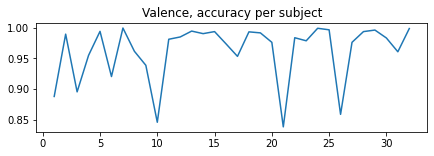

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 2))
ax.plot(np.arange(1,33), acc_subs)
ax.set_title("Valence, accuracy per subject")

In [ ]:
print(np.mean(acc_subs))
print(np.mean(f1_subs))

0.9620703125000001
0.9572812127077701


##Arousal

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

#def get_mertics_per_subject():
k  = 5
type_emotion = 1

acc_all = []
f1_all = []
for sub in range(18,32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
    n = len(indexes)
    #X = np.arange(40)
    y = []
    for nvideo in range(NVIDEOS):
        y.extend(60 * [labels_bin[sub][nvideo, type_emotion]])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(indexes, y)
    acc_sub = []
    f1_sub = []
    for fold,  (inds_train, inds_test) in  enumerate(balanced_split):
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset(data[sub : sub + 1], labels_bin[sub : sub + 1], transforms, inds_train)
        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                    pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset(data[sub: sub + 1], labels_bin[sub  : sub + 1], transforms,  inds_test)
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        description = f'arousal_racnn_leak_{sub}_{fold}'
        train_loop(description, 1, 30)
       
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion, True)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_arousal_racnn_leak_result2.csv")
    pd.DataFrame(acc_all).to_csv("acc_arousal_racnn_leak_result2.csv")



    

*******18*********
fold = 0
0.93125
[[105  27]
 [  6 342]]
              precision    recall  f1-score   support

           0       0.95      0.80      0.86       132
           1       0.93      0.98      0.95       348

    accuracy                           0.93       480
   macro avg       0.94      0.89      0.91       480
weighted avg       0.93      0.93      0.93       480

f1 = 0.9090862131308435 acc = 0.93125
0.93125 0.9090862131308435
fold = 1
0.94375
[[114  18]
 [  9 339]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       132
           1       0.95      0.97      0.96       348

    accuracy                           0.94       480
   macro avg       0.94      0.92      0.93       480
weighted avg       0.94      0.94      0.94       480

f1 = 0.9279098873591989 acc = 0.94375
0.94375 0.9279098873591989
fold = 2
0.9583333333333334
[[118  14]
 [  6 342]]
              precision    recall  f1-score   support

           

In [ ]:
print(f1_all)

[[0.9090862131308435, 0.9279098873591989, 0.9467329545454546, 0.9502484848154229, 0.9603434696159374], [0.9978279658447629, 1.0, 1.0, 1.0, 0.9956520951466512], [0.839267775421364, 0.8038314176245211, 0.8770258980785296, 0.6964304099071936, 0.819675415748347], [0.9817142857142857, 0.9785931357870526, 0.92867065094492, 0.9699331011500589, 0.9534808593119044], [0.9332765720838909, 0.9833321758455449, 0.9708287753294784, 0.9833333333333333, 0.9583326099411449], [0.9925446930122029, 1.0, 0.9950591868244982, 1.0, 0.9975247397109102], [0.9603876107040321, 0.9729165491169666, 0.8164627363737486, 0.9479110146500271, 0.9791652198069309], [0.997621866933546, 0.992865600800638, 0.9976297583834952, 1.0, 0.9905033238366572], [1.0, 0.991111111111111, 1.0, 0.9933552057809709, 1.0], [1.0, 1.0, 1.0, 0.995824562013953, 0.9937329996735937], [0.9789010989010989, 0.9681971774995031, 0.9627130681818181, 0.9840985887497515, 0.9260168403025546], [0.9785931357870526, 0.9817142857142857, 0.9879732404600235, 0.99

In [ ]:
import pandas as pd
f1_all1 = pd.read_csv("f1_arousal_racnn_leak_result_d.csv")
acc_all1 = pd.read_csv("acc_arousal_racnn_leak_result_d.csv")
f1_all2 = pd.read_csv("f1_arousal_racnn_leak_result2.csv")
acc_all2 = pd.read_csv("acc_arousal_racnn_leak_result2.csv")

In [ ]:
f1_all = pd.concat((f1_all1, f1_all2), axis = 0, ignore_index = True).reset_index()
acc_all = pd.concat((acc_all1, acc_all2), axis = 0)

In [ ]:
print(f1_all)

    index  Unnamed: 0         0         1         2         3         4
0       0           0  0.972665  0.978593  0.973206  0.972849  0.975946
1       1           1  0.981248  0.997917  0.979166  0.968747  0.977083
2       2           2  0.803831  0.868367  0.925766  0.810778  0.780093
3       3           3  0.970833  0.979161  0.970831  0.993750  0.972907
4       4           4  1.000000  0.997828  1.000000  0.995652  0.997828
5       5           5  0.976089  0.970776  0.968352  0.992107  0.978693
6       6           6  1.000000  1.000000  1.000000  1.000000  1.000000
7       7           7  0.968765  0.995236  0.985659  0.992866  0.997622
8       8           8  0.830010  0.841671  0.852931  0.830241  0.894498
9       9           9  0.933906  0.914596  0.914345  0.943358  0.940607
10     10          10  0.844667  0.919558  0.969084  0.914530  0.905754
11     11          11  0.975302  0.868118  0.808047  0.904556  0.811834
12     12          12  0.997896  0.997895  0.991589  0.997896  1

In [ ]:
pd.DataFrame(f1_all).to_csv("f1_arousal_racnn_leak_result_article.csv")
pd.DataFrame(acc_all).to_csv("acc_arousal_racnn_leak_result_article.csv")

In [ ]:
acc_data = pd.DataFrame(acc_all[['0','1','2','3', '4']])
acc_data_sub = acc_data.mean(axis = 1)

In [ ]:
f1_data = pd.DataFrame(f1_all[['0','1','2','3', '4']])
f1_data_sub = f1_data.mean(axis = 1)

In [ ]:
import numpy as np
print(np.mean(acc_data_sub))
print(np.mean(f1_data_sub))

0.9610286458333331
0.9459223225001052


Text(0.5, 1.0, 'Arousal, accuracy per subject')

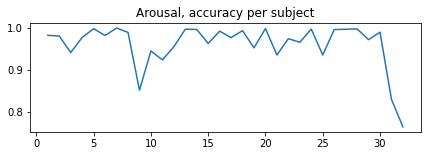

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 2))
ax.plot(np.arange(1,33), acc_data_sub.values)
ax.set_title("Arousal, accuracy per subject")

In [ ]:
print(f"Valence accuracy = {acc_data_sub.mean()} += {acc_data_sub.std()}" )

Valence accuracy = 0.9610286458333331 += 0.05387857469024103


#Результаты на датасете без лика

In [ ]:
import glob
import pickle
from collections import Counter
import scipy
from  scipy import signal
from scipy.fft import fft, fftfreq

class EmotionDataset_balanced(Dataset):
    def __init__ (self, indexes, data, labels_bin):  #indexes - индексы видео которые вошли в датасет, data - данные labels - метки бинарные
       self.data = []
       self.labels = []
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       self.indexes = indexes
       self.len_files = []
       for sub in range(len(data)): #sub   - человек
            self.data.append(data[sub][indexes[sub], :, 3 * NTIMES_IN_SEC :  LEN_RECORD_IN_SECONDS * NTIMES_IN_SEC + 3 * NTIMES_IN_SEC])
            self.len_files.append(len(indexes[sub]) *  LEN_RECORD_IN_SECONDS - 1) #столько записей будет храниться для каждого человека - количство видео для человека на 60 сек
            self.len_record = LEN_RECORD_IN_SECONDS
            labels_bin_sub = (labels_bin[sub])
            self.labels.append(labels_bin_sub[indexes[sub]])          
            # счетчик числа 1 и 0 в датасете
            for type_emotion in range(4):
              self.cnt[type_emotion].update(list(self.labels[-1][:, type_emotion]))    

            
       self.len_cumsum = np.cumsum(self.len_files)     


    # общее число сеймплов по 1 сек в датасете. их будет 32 * количество видео в датасете * 60 
    def __len__(self):
        result =  sum(self.len_files) - 10
        return result


    # по номеру сеймпла вытягиваем номер человека номер видео и номер секунды
    def get_index_record(self, item):
      for sub in range(len(self.len_cumsum)):
         #print(item, self.len_cumsum[i_file])
         if (item > self.len_cumsum[sub]):
            continue
         else:
            break
      if sub == 0:
         index_in_file = item
      else:
         index_in_file = item  - self.len_cumsum[sub - 1]
      nvideo = index_in_file//(self.len_record)# * LEN_RECORD_IN_SECONDS *  NTIMES_IN_SEC)
      nsec = (index_in_file - nvideo * self.len_record) # *   NTIMES_IN_SEC)

      return sub, nvideo, nsec

   
    def __getitem__(self, item):
      sample = {}
      #print(item)
      sub, nvideo, nsec = self.get_index_record(item)
      #print(i_file, index_in_file, nvideo, nsec )
      sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
      sample_from_one_canals = []
      for i_canal in range(NCANALS):
        sample_from_one_canal1 = self.data[sub][nvideo, i_canal, nsec * 128 : nsec * 128 + 128]
        power = fft(sample_from_one_canal1)
        #sample_from_one_canals.append(sample_from_one_canal)
        sample_from_one_canals.append([0] * 128)
        #print(sample_from_one_canal.shape)
      sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      # здесь делаем нормализацию фактически по поверхности головы (по одному времени t для всех каналов)
      #sample_from_one_canals = scipy.stats.zscore(sample_from_one_canals, axis = 0)
      for i_canal in range(NCANALS):
          sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
      sample['data'] = torch.FloatTensor(sample['data'])
      sample['labels']  = torch.LongTensor(self.labels[sub][nvideo])
      sample['position'] = torch.LongTensor((sub, nvideo, nsec))
      
      return sample

Valence Correct Per sub model

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd


#def get_mertics_per_subject():
k  = 5
type_emotion = 0
acc_all = []
f1_all = []

for sub in range(0, 32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    X = np.arange(40)
    y = np.array(labels_bin[sub][:, type_emotion])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(X, y)
    acc_sub = []
    f1_sub = []
   
    for fold,  (ind_train, ind_test) in  enumerate(balanced_split):
        inds_train = []
        inds_test = []
        inds_train.append(ind_train)
        inds_test.append(ind_test)
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset_balanced(inds_train[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
       

        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset_balanced(inds_test[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                      pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper', 0, 20)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion, True)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_data_val_racnn_noleak.csv")
    pd.DataFrame(acc_all).to_csv("acc_data_val_racnn_noleak.csv")

In [ ]:
import pandas as pd

f1_data_val_noleak = pd.read_csv("f1_data_val_noleak.csv")
acc_data_val_noleak = pd.read_csv("acc_data_val_noleak.csv")

In [ ]:
print(f1_data_val_noleak)

In [ ]:
f1 = f1_data_val_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
acc = acc_data_val_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
print(f1.mean())
print(acc.mean())
print(f1.std())
print(acc.std())

Arrousal Correct Per sub model

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

#def get_mertics_per_subject():
k  = 5
type_emotion = 1
#acc_all = []
#f1_all = []

for sub in range(1, 32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    X = np.arange(40)
    y = np.array(labels_bin[sub][:, type_emotion])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(X, y)
    acc_sub = []
    f1_sub = []
   
    for fold,  (ind_train, ind_test) in  enumerate(balanced_split):
        inds_train = []
        inds_test = []
        inds_train.append(ind_train)
        inds_test.append(ind_test)
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset_balanced(inds_train[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
       

        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset_balanced(inds_test[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                      pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper', 0, 20)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_data_val_noleak.csv")
    pd.DataFrame(acc_all).to_csv("acc_data_val_noleak.csv")

In [ ]:
import pandas as pd

f1_data_arousal_noleak = pd.read_csv("f1_data_racnn_arousal_noleak.csv")
acc_data_arousal_noleak = pd.read_csv("acc_data_racnn_arousal_noleak.csv")

In [ ]:
print(f1_data_arousal_noleak)

In [ ]:

print(acc_data_arousal_noleak)

In [ ]:
f1 = f1_data_arousal_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
acc = acc_data_arousal_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
print(f1.mean())
print(acc.mean())
print(f1.std())
print(acc.std())